In [1]:
import pandas as pd
# from catboost import CatBoostRegressor, CatBoostClassifier
# from xgboost import XGBRegressor, XGBClassifier
# from sklearn.neighbors import KNeighborsRegressor
# from sklearn.svm import SVR
# from sklearn.linear_model import LogisticRegression
import numpy as np
import os
from sklearn.metrics import log_loss, roc_auc_score, accuracy_score

valid_set = pd.read_csv('validation.csv')
train_set = pd.read_csv('train_set.csv')
features = [col for col in valid_set.columns if col not in ['Match', 'Label']]
X_train = train_set[features]
y_train = train_set['Label']
X_valid = valid_set[features]
y_valid = valid_set['Label']
n_features = len(features)
save_directory = r"D:\NCAA\ModelDeployment\trained_models"



In [28]:
Comp_data_root_dir = r'D:\NCAA\march-machine-learning-mania-2025' 
compact_season_results = pd.read_csv(os.path.join(Comp_data_root_dir,'MRegularSeasonCompactResults.csv'))
compact_season_results = compact_season_results[compact_season_results['Season']>=2018]
compact_season_results = compact_season_results.iloc[::-1]
#This dataframe contains the results from the past years. Those will serve as the targets for the training pipeline
#We will exclude all seasonal data sooner than 2018 since older stats are not representative of their current capabilities at all. 
#too much missing data from older results.

In [29]:
kenpom_massey_metrics = pd.read_csv(r'Eng_data\DataSource.csv')
missing_counts = (kenpom_massey_metrics == "--").sum()
missing_counts_sorted = missing_counts.sort_values(ascending=False)

missing_counts_sorted

JJK           8
RT            4
LMC           2
7OT           2
TRK           0
MOR           0
DII           0
TRP           0
MAS           0
BBT           0
PGH           0
KPK           0
DOK           0
HAS           0
FAS           0
EBP           0
BIH           0
Unnamed: 0    0
Season        0
Seed          0
TeamID        0
TeamName      0
count         0
win_count     0
gap_avg       0
win_rate      0
Rating        0
JNG           0
Rk            0
NetRtg        0
ORtg          0
DRtg          0
AdjT          0
WIL           0
WLK           0
dtype: int64

In [30]:
kenpom_massey_metrics = pd.read_csv(r'Eng_data\DataSource.csv')
#Those are the metrics from individual commentators and contains the elo information that I calculated myself
#Those are the elo ratings calculated for each team in each season
kenpom_massey_metrics  = kenpom_massey_metrics.drop(['Unnamed: 0','7OT','JJK','RT','LMC'],axis=1) 
#dropping '7OT','JJK','RT','LMC' because they contain Null values


In [31]:
kenpom_massey_metrics.head()

,Season,TeamID,TeamName,count,win_count,gap_avg,win_rate,Seed,Rating,Rk,...,DOK,PGH,BBT,BIH,TRP,DII,MOR,TRK,KPK,WLK
0,2025,1120,Auburn,33,28,14.242424,0.848485,1.0,65.690297,4,...,3,1,2,1,2,1,4,3,1,2
1,2025,1181,Duke,34,31,20.794118,0.911765,1.0,66.375404,1,...,1,4,1,3,1,2,1,2,2,1
2,2025,1196,Florida,34,30,16.176471,0.882353,1.0,66.166661,2,...,2,2,3,2,4,3,2,4,4,3
3,2025,1222,Houston,34,30,15.735294,0.882353,1.0,68.295069,3,...,4,3,4,4,3,4,3,1,3,4
4,2025,1104,Alabama,33,25,9.696970,0.757576,2.0,64.908072,6,...,5,5,6,6,5,5,5,5,5,5


In [32]:
kenpom_massey_metrics.columns

Index(['Season', 'TeamID', 'TeamName', 'count', 'win_count', 'gap_avg',
       'win_rate', 'Seed', 'Rating', 'Rk', 'NetRtg', 'ORtg', 'DRtg', 'AdjT',
       'WIL', 'JNG', 'MAS', 'EBP', 'FAS', 'HAS', 'DOK', 'PGH', 'BBT', 'BIH',
       'TRP', 'DII', 'MOR', 'TRK', 'KPK', 'WLK'],
      dtype='object')

In [33]:
row = pd.Series({"Season": 2024, "TeamID": 1120, "TeamName": "Auburn"})
row = pd.DataFrame([row])

exists = not row.merge(
    kenpom_massey_metrics, 
    on=["Season", "TeamID", "TeamName"], 
    how="left", 
    indicator=True
)["_merge"].eq("left_only").any()
exists

#Works!

True

In [34]:
compact_season_results

,Season,DayNum,WTeamID,WScore,LTeamID,LScore,WLoc,NumOT
192929,2025,132,1463,90,1165,84,N,0
192928,2025,132,1433,68,1206,63,N,0
192927,2025,132,1276,59,1458,53,N,0
192926,2025,132,1272,84,1412,72,N,0
192925,2025,132,1196,86,1397,77,N,0
...,...,...,...,...,...,...,...,...
150688,2018,11,1116,95,1359,56,H,0
150687,2018,11,1113,94,1226,74,H,0
150686,2018,11,1112,101,1319,67,H,0
150685,2018,11,1107,69,1233,67,H,0


In [35]:
for _, row in compact_season_results[0:5].iterrows(): 
    print(row['WTeamID'])

1463
1433
1276
1272
1196


In [36]:
common_stats = [c for c in kenpom_massey_metrics.columns if c not in ['Season','TeamID','TeamName']]
non_numeric_cols = []
for column in common_stats:
    if kenpom_massey_metrics[f'{column}'].dtype != 'float64':
        non_numeric_cols.append(column)


kenpom_massey_metrics[non_numeric_cols] = kenpom_massey_metrics[non_numeric_cols].apply(pd.to_numeric)


In [37]:

train_set = []
missing_count = 0

for _, row in compact_season_results.iterrows():
    # Check if stats exist for both teams
    w_exists = ((kenpom_massey_metrics["TeamID"] == row["WTeamID"]) & 
                (kenpom_massey_metrics["Season"] == row["Season"])).any()
    l_exists = ((kenpom_massey_metrics["TeamID"] == row["LTeamID"]) & 
                (kenpom_massey_metrics["Season"] == row["Season"])).any()

    if w_exists and l_exists:
        w_stats = kenpom_massey_metrics[
            (kenpom_massey_metrics["TeamID"] == row['WTeamID']) &
            (kenpom_massey_metrics["Season"] == row['Season'])
        ].iloc[0]

        l_stats = kenpom_massey_metrics[
            (kenpom_massey_metrics["TeamID"] == row['LTeamID']) &
            (kenpom_massey_metrics["Season"] == row['Season'])
        ].iloc[0]

        if np.random.rand() > 0.5: #We need to randomize the order because if we just use the order of teams in 
            #compact_season_results, the label is always one as WTeam always come first.
            team_a_stats, team_b_stats = w_stats, l_stats
            team_a_id, team_b_id = row['WTeamID'], row['LTeamID']
            label = 1  # team_a won
        else:
            team_a_stats, team_b_stats = l_stats, w_stats
            team_a_id, team_b_id = row['LTeamID'], row['WTeamID']
            label = 0  # team_a lost

        new_row = {"Match": f"{row['Season']}_{team_a_id}_{team_b_id}", "Label": label}
        for column in common_stats:
            new_row[f"dif_{column}"] = team_a_stats[column] - team_b_stats[column]

        team_a_features = team_a_stats[common_stats].add_prefix("team_a_")
        team_b_features = team_b_stats[common_stats].add_prefix("team_b_")
        new_row.update(team_a_features)
        new_row.update(team_b_features)
        train_set.append(new_row)
    else:
        missing_count += 1

train_set = pd.DataFrame(train_set)
print(f"Missing matches: {missing_count}") #well well well....


Missing matches: 5662


In [38]:
valid_set = train_set[train_set['Match'].str.startswith('2025')]
train_set = train_set[~train_set['Match'].str.startswith('2025')]


In [ ]:
valid_set.to_csv('validation.csv')
train_set.to_csv("train_set.csv")


In [ ]:

features = [col for col in valid_set.columns if col not in ['Match', 'Label']]

In [40]:
from sklearn.metrics import mean_squared_error
X_train = train_set[features]
y_train = train_set['Label']
X_valid = valid_set[features]
y_valid = valid_set['Label']

In [41]:
print("Training XGBoost...")
xgb_model = XGBRegressor(objective='reg:squarederror', n_estimators=1000, learning_rate=0.05, random_state=42)
xgb_model.fit(X_train, y_train)
y_pred_xgb = xgb_model.predict(X_valid)
mse_xgb = mean_squared_error(y_valid, y_pred_xgb)
print(f"XGBoost MSE: {mse_xgb:.4f}\n")

Training XGBoost...
XGBoost MSE: 0.1666



In [42]:
print("Training CatBoost...")
cat_model = CatBoostRegressor(iterations=1000, learning_rate=0.05, random_state=42, verbose=0) 
cat_model.fit(X_train, y_train)
y_pred_cat = cat_model.predict(X_valid)
mse_cat = mean_squared_error(y_valid, y_pred_cat)
print(f"CatBoost MSE: {mse_cat:.4f}\n")

Training CatBoost...
CatBoost MSE: 0.1618



In [43]:
# print("Training SVR...")
# svr_model = SVR(kernel='rbf', C=100, gamma=0.1, epsilon=.1)
# svr_model.fit(X_train, y_train)
# y_pred_svr = svr_model.predict(X_valid)
# mse_svr = mean_squared_error(y_valid, y_pred_svr)
# print(f"SVR MSE: {mse_svr:.4f}") #too long to train im NOT waitng

Regression Methods are absolutely pathetic. Lets try classification

In [ ]:

print("Training XGBClassifier...")
xgb_model = XGBClassifier(objective='binary:logistic', eval_metric='logloss', use_label_encoder=False, random_state=42)
xgb_model.fit(X_train, y_train)

y_pred_proba = xgb_model.predict_proba(X_valid)[:, 1]
logloss = log_loss(y_valid, y_pred_proba)
auc = roc_auc_score(y_valid, y_pred_proba)
y_pred_class = xgb_model.predict(X_valid)
accuracy = accuracy_score(y_valid, y_pred_class)


print(f"Log Loss: {logloss:.4f}")
print(f"AUC-ROC Score: {auc:.4f}")
print(f"Accuracy: {accuracy:.4f}\n")


Training XGBClassifier...


c:\Users\jimmy\miniconda3\envs\NCAA\Lib\site-packages\xgboost\training.py:183: UserWarning: [23:05:26] WARNING: D:\bld\xgboost-split_1757347776742\work\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Log Loss: 0.5000
AUC-ROC Score: 0.8343
Accuracy: 0.7511



In [ ]:
print("Training CatBoostClassifier...")
cat_model = CatBoostClassifier(
    iterations=1000,
    learning_rate=0.05,
    random_seed=42,
    verbose=0  # suppress training yap
)
cat_model.fit(X_train, y_train)
y_pred_proba = cat_model.predict_proba(X_valid)[:, 1]
logloss = log_loss(y_valid, y_pred_proba)
auc = roc_auc_score(y_valid, y_pred_proba)
y_pred_class = cat_model.predict(X_valid)
accuracy = accuracy_score(y_valid, y_pred_class)
print(f"Log Loss: {logloss:.4f}")
print(f"AUC-ROC Score: {auc:.4f}")
print(f"Accuracy: {accuracy:.4f}\n")

Training CatBoostClassifier...
Log Loss: 0.4833
AUC-ROC Score: 0.8435
Accuracy: 0.7568\n


Classifiers are not bad at all.(significantly better than random guessing) Now we just need to finetune the hyperparameters.

In [51]:
from sklearn.model_selection import RandomizedSearchCV
import scipy.stats as stats

param_dist_xgb = {
    'max_depth': stats.randint(3, 10),
    'min_child_weight': stats.randint(1, 10),
    'gamma': stats.uniform(0, 5),

    'subsample': stats.uniform(0.6, 0.4), 
    'colsample_bytree': stats.uniform(0.6, 0.4), 
    'reg_alpha': stats.uniform(0, 1),
    'reg_lambda': stats.uniform(1, 10),

    'learning_rate': stats.uniform(0.01, 0.2),
    'n_estimators': stats.randint(100, 1000)
}

xgb_model = XGBClassifier()
random_search_xgb = RandomizedSearchCV(xgb_model, param_distributions=param_dist_xgb, n_iter=10, cv=5, scoring='accuracy')
random_search_xgb.fit(X_train, y_train)
print("Best set of hyperparameters: ", random_search_xgb.best_params_)
print("Best score: ", random_search_xgb.best_score_)
best_xgb_model = random_search_xgb.best_estimator_

Best set of hyperparameters:  {'colsample_bytree': 0.9670201830907493, 'gamma': 2.732393115168099, 'learning_rate': 0.04638220506975805, 'max_depth': 4, 'min_child_weight': 7, 'n_estimators': 209, 'reg_alpha': 0.8636747938106635, 'reg_lambda': 3.90207802967959, 'subsample': 0.9906146186454989}
Best score:  0.7559064432663702


In [ ]:
y_pred_class = best_xgb_model.predict(X_valid)
accuracy = accuracy_score(y_valid, y_pred_class)
print(accuracy) 

0.7589079950363411


In [54]:
param_dist_cat = {
    'depth': stats.randint(4, 10),
    'min_data_in_leaf': stats.randint(1, 20),

    'l2_leaf_reg': stats.uniform(1, 10),
    'random_strength': stats.uniform(1, 10),
    'bootstrap_type': ['Bayesian', 'Bernoulli', 'MVS'], 
    'subsample': stats.uniform(0.6, 0.4),


    'learning_rate': stats.uniform(0.01, 0.2),
    'iterations': stats.randint(100, 1000)
}

cat_model = CatBoostClassifier()
random_search_cat = RandomizedSearchCV(cat_model, param_distributions=param_dist_cat, n_iter=10, cv=5, scoring='accuracy')
random_search_cat.fit(X_train, y_train)
print("Best set of hyperparameters: ", random_search_cat.best_params_)
print("Best score: ", random_search_cat.best_score_)
best_cat_model = random_search_cat.best_estimator_

0:	learn: 0.6450328	total: 49.6ms	remaining: 32.2s
1:	learn: 0.6111394	total: 91.6ms	remaining: 29.7s
2:	learn: 0.5856079	total: 130ms	remaining: 28.1s
3:	learn: 0.5642780	total: 169ms	remaining: 27.4s
4:	learn: 0.5481721	total: 209ms	remaining: 27.1s
5:	learn: 0.5360855	total: 248ms	remaining: 26.7s
6:	learn: 0.5253224	total: 290ms	remaining: 26.6s
7:	learn: 0.5179282	total: 328ms	remaining: 26.4s
8:	learn: 0.5116067	total: 369ms	remaining: 26.3s
9:	learn: 0.5072328	total: 406ms	remaining: 26s
10:	learn: 0.5032026	total: 448ms	remaining: 26.1s
11:	learn: 0.4999641	total: 490ms	remaining: 26.1s
12:	learn: 0.4975881	total: 531ms	remaining: 26.1s
13:	learn: 0.4956492	total: 572ms	remaining: 26s
14:	learn: 0.4936508	total: 616ms	remaining: 26.1s
15:	learn: 0.4922365	total: 662ms	remaining: 26.3s
16:	learn: 0.4910277	total: 703ms	remaining: 26.2s
17:	learn: 0.4895806	total: 749ms	remaining: 26.3s
18:	learn: 0.4887674	total: 797ms	remaining: 26.5s
19:	learn: 0.4880626	total: 845ms	remaining

c:\Users\jimmy\miniconda3\envs\NCAA\Lib\site-packages\sklearn\model_selection\_validation.py:516: FitFailedWarning: 
15 fits failed out of a total of 50.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
15 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\jimmy\miniconda3\envs\NCAA\Lib\site-packages\sklearn\model_selection\_validation.py", line 859, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\jimmy\miniconda3\envs\NCAA\Lib\site-packages\catboost\core.py", line 5245, in fit
    self._fit(X, y, cat_features, text_features, embedding_features, None, graph, sample_weight, None, None, None, None, baseline, use_best_model,
  File "c:\Users\jimmy\miniconda3\envs\NCA

1:	learn: 0.6426548	total: 35.5ms	remaining: 2.09s
2:	learn: 0.6220534	total: 52.5ms	remaining: 2.05s
3:	learn: 0.6039073	total: 69.3ms	remaining: 2.01s
4:	learn: 0.5896140	total: 86ms	remaining: 1.98s
5:	learn: 0.5761645	total: 102ms	remaining: 1.95s
6:	learn: 0.5650143	total: 119ms	remaining: 1.91s
7:	learn: 0.5560380	total: 135ms	remaining: 1.89s
8:	learn: 0.5485465	total: 151ms	remaining: 1.87s
9:	learn: 0.5416961	total: 168ms	remaining: 1.85s
10:	learn: 0.5360777	total: 186ms	remaining: 1.84s
11:	learn: 0.5310080	total: 204ms	remaining: 1.84s
12:	learn: 0.5260221	total: 221ms	remaining: 1.82s
13:	learn: 0.5224710	total: 244ms	remaining: 1.84s
14:	learn: 0.5185600	total: 262ms	remaining: 1.83s
15:	learn: 0.5154754	total: 279ms	remaining: 1.81s
16:	learn: 0.5127219	total: 297ms	remaining: 1.8s
17:	learn: 0.5099452	total: 314ms	remaining: 1.78s
18:	learn: 0.5080487	total: 332ms	remaining: 1.76s
19:	learn: 0.5062439	total: 348ms	remaining: 1.74s
20:	learn: 0.5045912	total: 364ms	remai

CATBOOST:
Best set of hyperparameters:  {'bootstrap_type': 'Bernoulli', 'depth': 7, 'iterations': 120, 'l2_leaf_reg': 3.7358654703494234, 'learning_rate': 0.06743138576068262, 'min_data_in_leaf': 5, 'random_strength': 1.3855282798457216, 'subsample': 0.6423092874701422}
Best score:  0.7566175125854062

XGBOOST: 
Best set of hyperparameters:  {'colsample_bytree': 0.9670201830907493, 'gamma': 2.732393115168099, 'learning_rate': 0.04638220506975805, 'max_depth': 4, 'min_child_weight': 7, 'n_estimators': 209, 'reg_alpha': 0.8636747938106635, 'reg_lambda': 3.90207802967959, 'subsample': 0.9906146186454989}
Best score:  0.7559064432663702

In [56]:
y_pred_class = best_cat_model.predict(X_valid)
accuracy = accuracy_score(y_valid, y_pred_class)
print(accuracy)

0.7596170891685872


In [ ]:
common_stats = [c for c in kenpom_massey_metrics.columns if c not in ['Season','TeamID','TeamName']]
non_numeric_cols = []
for column in common_stats:
    if kenpom_massey_metrics[f'{column}'].dtype != 'float64':
        non_numeric_cols.append(column)


kenpom_massey_metrics[non_numeric_cols] = kenpom_massey_metrics[non_numeric_cols].apply(pd.to_numeric)


        Before HyperTune             After HyperTune
xgb            0.7511               0.7589079950363411
cat            0.7568               0.7596170891685872


Yeah im not getting anywhere with this

In [ ]:
import os
import onnx
import onnxmltools
from onnxmltools.convert.common.data_types import FloatTensorType

save_directory = r"D:\NCAA\ModelDeployment\trained_models" 
xgb_model_filename = "xgboost_model.onnx"
xgb_full_path = os.path.join(save_directory, xgb_model_filename)


os.makedirs(save_directory, exist_ok=True)


print("Converting the CatBoost model to ONNX format...")
cat_model_filename = r'catboost_model.onnx'
cat_full_path = os.path.join(save_directory, cat_model_filename)
best_cat_model.save_model(
    fname =cat_full_path,
    format = 'onnx',
    export_parameters=None,
    pool = None 
)
print("Conversion successful.")
print(f"Model saved successfully to {cat_full_path}")


Converting the CatBoost model to ONNX format...
Conversion successful.
Model saved successfully to D:\NCAA\ModelDeployment\trained_models\catboost_model.onnx


In [67]:
import re
initial_type = [('float_input', FloatTensorType([None, n_features]))]


print("--- Step 2: Sanitizing Feature Names ---")

# This is the critical step to make the model ONNX-compatible.

best_xgb_model.get_booster().feature_names = columns = [f"f{num}" for num in range(n_features)]

print("Original feature names:", features)
print("Sanitized feature names:", best_xgb_model.get_booster().feature_names)

print("Converting the XGBoost model to ONNX format...")
onnx_model = onnxmltools.convert_xgboost(
    best_xgb_model, 
    initial_types=initial_type
)
print("Conversion successful.")

print(f"Saving model to: {xgb_full_path}")
with open(xgb_full_path, "wb") as f:
    f.write(onnx_model.SerializeToString())

print(f"Model saved successfully to {xgb_full_path}")


--- Step 2: Sanitizing Feature Names ---
Original feature names: ['dif_count', 'dif_win_count', 'dif_gap_avg', 'dif_win_rate', 'dif_Seed', 'dif_Rating', 'dif_Rk', 'dif_NetRtg', 'dif_ORtg', 'dif_DRtg', 'dif_AdjT', 'dif_WIL', 'dif_JNG', 'dif_MAS', 'dif_EBP', 'dif_FAS', 'dif_HAS', 'dif_DOK', 'dif_PGH', 'dif_BBT', 'dif_BIH', 'dif_TRP', 'dif_DII', 'dif_MOR', 'dif_TRK', 'dif_KPK', 'dif_WLK', 'team_a_count', 'team_a_win_count', 'team_a_gap_avg', 'team_a_win_rate', 'team_a_Seed', 'team_a_Rating', 'team_a_Rk', 'team_a_NetRtg', 'team_a_ORtg', 'team_a_DRtg', 'team_a_AdjT', 'team_a_WIL', 'team_a_JNG', 'team_a_MAS', 'team_a_EBP', 'team_a_FAS', 'team_a_HAS', 'team_a_DOK', 'team_a_PGH', 'team_a_BBT', 'team_a_BIH', 'team_a_TRP', 'team_a_DII', 'team_a_MOR', 'team_a_TRK', 'team_a_KPK', 'team_a_WLK', 'team_b_count', 'team_b_win_count', 'team_b_gap_avg', 'team_b_win_rate', 'team_b_Seed', 'team_b_Rating', 'team_b_Rk', 'team_b_NetRtg', 'team_b_ORtg', 'team_b_DRtg', 'team_b_AdjT', 'team_b_WIL', 'team_b_JNG',

In [71]:
#Load them back just to confirm
import onnxruntime as rt
#print(rt.get_available_providers())
#prints ['AzureExecutionProvider', 'CPUExecutionProvider']
save_directory = r"D:\NCAA\ModelDeployment\trained_models"
xgb_model_path = os.path.join(save_directory, "xgboost_model.onnx")
cat_model_path = os.path.join(save_directory, "catboost_model.onnx")
xgb_session = rt.InferenceSession(xgb_model_path, providers=['CPUExecutionProvider'])
cat_session = rt.InferenceSession(cat_model_path, providers=['CPUExecutionProvider'])

print("Models loaded successfully.")
#onnx runtimes needs np array
X_valid_numpy = np.array(X_valid).astype(np.float32)

print("\nRunning inference on the validation set...")

# Get the input and output names for both models
xgb_input_name = xgb_session.get_inputs()[0].name
xgb_output_names = [output.name for output in xgb_session.get_outputs()]

cat_input_name = cat_session.get_inputs()[0].name
cat_output_names = [output.name for output in cat_session.get_outputs()]

# Run predictions
xgb_onnx_preds = xgb_session.run(xgb_output_names, {xgb_input_name: X_valid_numpy})
cat_onnx_preds = cat_session.run(cat_output_names, {cat_input_name: X_valid_numpy})


# Index 0: The predicted labels
# Index 1: The predicted probabilities

# --- XGBoost Metrics ---
xgb_predicted_labels = xgb_onnx_preds[0]
xgb_predicted_probas = xgb_onnx_preds[1]

xgb_accuracy = accuracy_score(y_valid, xgb_predicted_labels)

xgb_probas_class_1 = [prob[1] for prob in xgb_predicted_probas]
xgb_auc = roc_auc_score(y_valid, xgb_probas_class_1)
xgb_logloss = log_loss(y_valid, xgb_probas_class_1)

# --- CatBoost Metrics ---
cat_predicted_labels = cat_onnx_preds[0]
cat_predicted_probas = cat_onnx_preds[1]
cat_probas_class_1 = [prob[1] for prob in cat_predicted_probas]

cat_accuracy = accuracy_score(y_valid, cat_predicted_labels)
cat_auc = roc_auc_score(y_valid, cat_probas_class_1)
cat_logloss = log_loss(y_valid, cat_probas_class_1)


# --- 4. PRINT THE FINAL RESULTS ---
print("\n--- Final Validation Metrics from ONNX Models ---")
print("\n--- XGBoost ---")
print(f"Accuracy: {xgb_accuracy:.4f}")
print(f"AUC-ROC:  {xgb_auc:.4f}")
print(f"Log Loss: {xgb_logloss:.4f}")

print("\n--- CatBoost ---")
print(f"Accuracy: {cat_accuracy:.4f}")
print(f"AUC-ROC:  {cat_auc:.4f}")
print(f"Log Loss: {cat_logloss:.4f}")

Models loaded successfully.

Running inference on the validation set...

--- Final Validation Metrics from ONNX Models ---

--- XGBoost ---
Accuracy: 0.7589
AUC-ROC:  0.8438
Log Loss: 0.4827

--- CatBoost ---
Accuracy: 0.7596
AUC-ROC:  0.8433
Log Loss: 0.4850


Works ALRIGHT

炼丹 
YOU NEED TORCH 2.7.0 FOR THIS TO WORK. 
The latest version has this stupid bug with profiler

In [9]:
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_auc_score, accuracy_score
import numpy as np 

class BinaryClassifier(nn.Module):
    def __init__(self, input_features):
        super().__init__()
        
        self.fc1 = nn.Linear(input_features, 256)
        self.bn1 = nn.BatchNorm1d(256)
        
        self.fc2 = nn.Linear(256, 128)
        self.bn2 = nn.BatchNorm1d(128)
        
        self.fc3 = nn.Linear(128, 64)
        self.bn3 = nn.BatchNorm1d(64)
        
        self.fc_out = nn.Linear(64, 1)
        
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(p=0.4) 
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = self.fc1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.dropout(x)
        
        x = self.fc2(x)
        x = self.bn2(x)
        x = self.relu(x)
        x = self.dropout(x)
        
        x = self.fc3(x)
        x = self.bn3(x)
        x = self.relu(x)
        
        x = self.fc_out(x)
        x = self.sigmoid(x)
        
        return x

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_valid_scaled = scaler.transform(X_valid)

X_train_nn = torch.tensor(X_train_scaled, dtype=torch.float32)
y_train_nn = torch.tensor(y_train, dtype=torch.float32).unsqueeze(1)
X_valid_nn = torch.tensor(X_valid_scaled, dtype=torch.float32)
y_valid_nn = torch.tensor(y_valid, dtype=torch.float32).unsqueeze(1)


input_features = X_train_nn.shape[1] 
model = BinaryClassifier(input_features=input_features) 
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-5)


epoch_count = []
train_losses = []
valid_losses = []
train_auc_scores = []
valid_auc_scores = []
valid_accuracies = []


epochs = 200
checkpoint_count = 1
nn_dir = os.path.join(save_directory, 'NN')
example_inputs = (torch.randn(1,82),)
for epoch in range(epochs):
    model.train()

    y_pred_train = model(X_train_nn)
    loss_train = criterion(y_pred_train, y_train_nn)

    optimizer.zero_grad()
    loss_train.backward()
    optimizer.step()

    model.eval()
    with torch.no_grad():
        train_auc = roc_auc_score(y_train_nn.numpy(), y_pred_train.numpy())
        
        y_pred_valid = model(X_valid_nn)
        #the batch looks like torch.Size([30943, 82]) because I can
        loss_valid = criterion(y_pred_valid, y_valid_nn)
        valid_auc = roc_auc_score(y_valid_nn.numpy(), y_pred_valid.numpy())
        
        valid_pred_class = y_pred_valid.round()
        valid_accuracy = accuracy_score(y_valid_nn.numpy(), valid_pred_class.numpy())
        
        epoch_count.append(epoch)
        train_losses.append(loss_train.item())
        valid_losses.append(loss_valid.item())
        train_auc_scores.append(train_auc)
        valid_auc_scores.append(valid_auc)
        valid_accuracies.append(valid_accuracy)
    
    if (epoch+1) % 20 == 0:
        onnx_program = torch.onnx.export(model, example_inputs, dynamo=True)
        print(f"Saving the {checkpoint_count}th model,")
        onnx_program_path = os.path.join(nn_dir,f'checkpoint_{checkpoint_count}.onnx')
        onnx_program.save(onnx_program_path)
        checkpoint_count += 1 
        print(f'Epoch [{epoch+1}/{epochs}], Train Loss: {loss_train.item():.4f}, Valid Loss: {loss_valid.item():.4f}, Valid AUC: {valid_auc:.4f}, Valid Acc: {valid_accuracy:.4f}')



W0910 01:07:39.119000 32496 site-packages\torch\onnx\_internal\exporter\_registration.py:107] torchvision is not installed. Skipping torchvision::nms


[torch.onnx] Obtain model graph for `BinaryClassifier([...]` with `torch.export.export(..., strict=False)`...
[torch.onnx] Obtain model graph for `BinaryClassifier([...]` with `torch.export.export(..., strict=False)`... ✅
[torch.onnx] Run decomposition...
[torch.onnx] Run decomposition... ✅
[torch.onnx] Translate the graph into ONNX...
[torch.onnx] Translate the graph into ONNX... ✅
Saving the 1th model,
Epoch [20/200], Train Loss: 0.4991, Valid Loss: 0.5017, Valid AUC: 0.8381, Valid Acc: 0.7539


W0910 01:07:44.891000 32496 site-packages\torch\onnx\_internal\exporter\_registration.py:107] torchvision is not installed. Skipping torchvision::nms


[torch.onnx] Obtain model graph for `BinaryClassifier([...]` with `torch.export.export(..., strict=False)`...
[torch.onnx] Obtain model graph for `BinaryClassifier([...]` with `torch.export.export(..., strict=False)`... ✅
[torch.onnx] Run decomposition...
[torch.onnx] Run decomposition... ✅
[torch.onnx] Translate the graph into ONNX...
[torch.onnx] Translate the graph into ONNX... ✅
Saving the 2th model,
Epoch [40/200], Train Loss: 0.4942, Valid Loss: 0.4868, Valid AUC: 0.8420, Valid Acc: 0.7559


W0910 01:07:50.850000 32496 site-packages\torch\onnx\_internal\exporter\_registration.py:107] torchvision is not installed. Skipping torchvision::nms


[torch.onnx] Obtain model graph for `BinaryClassifier([...]` with `torch.export.export(..., strict=False)`...
[torch.onnx] Obtain model graph for `BinaryClassifier([...]` with `torch.export.export(..., strict=False)`... ✅
[torch.onnx] Run decomposition...
[torch.onnx] Run decomposition... ✅
[torch.onnx] Translate the graph into ONNX...
[torch.onnx] Translate the graph into ONNX... ✅
Saving the 3th model,
Epoch [60/200], Train Loss: 0.4905, Valid Loss: 0.4848, Valid AUC: 0.8431, Valid Acc: 0.7578


W0910 01:07:56.724000 32496 site-packages\torch\onnx\_internal\exporter\_registration.py:107] torchvision is not installed. Skipping torchvision::nms


[torch.onnx] Obtain model graph for `BinaryClassifier([...]` with `torch.export.export(..., strict=False)`...
[torch.onnx] Obtain model graph for `BinaryClassifier([...]` with `torch.export.export(..., strict=False)`... ✅
[torch.onnx] Run decomposition...
[torch.onnx] Run decomposition... ✅
[torch.onnx] Translate the graph into ONNX...
[torch.onnx] Translate the graph into ONNX... ✅
Saving the 4th model,
Epoch [80/200], Train Loss: 0.4883, Valid Loss: 0.4841, Valid AUC: 0.8436, Valid Acc: 0.7566


W0910 01:08:02.428000 32496 site-packages\torch\onnx\_internal\exporter\_registration.py:107] torchvision is not installed. Skipping torchvision::nms


[torch.onnx] Obtain model graph for `BinaryClassifier([...]` with `torch.export.export(..., strict=False)`...
[torch.onnx] Obtain model graph for `BinaryClassifier([...]` with `torch.export.export(..., strict=False)`... ✅
[torch.onnx] Run decomposition...
[torch.onnx] Run decomposition... ✅
[torch.onnx] Translate the graph into ONNX...
[torch.onnx] Translate the graph into ONNX... ✅
Saving the 5th model,
Epoch [100/200], Train Loss: 0.4882, Valid Loss: 0.4837, Valid AUC: 0.8438, Valid Acc: 0.7578


W0910 01:08:08.486000 32496 site-packages\torch\onnx\_internal\exporter\_registration.py:107] torchvision is not installed. Skipping torchvision::nms


[torch.onnx] Obtain model graph for `BinaryClassifier([...]` with `torch.export.export(..., strict=False)`...
[torch.onnx] Obtain model graph for `BinaryClassifier([...]` with `torch.export.export(..., strict=False)`... ✅
[torch.onnx] Run decomposition...
[torch.onnx] Run decomposition... ✅
[torch.onnx] Translate the graph into ONNX...
[torch.onnx] Translate the graph into ONNX... ✅
Saving the 6th model,
Epoch [120/200], Train Loss: 0.4861, Valid Loss: 0.4836, Valid AUC: 0.8439, Valid Acc: 0.7575


W0910 01:08:14.573000 32496 site-packages\torch\onnx\_internal\exporter\_registration.py:107] torchvision is not installed. Skipping torchvision::nms


[torch.onnx] Obtain model graph for `BinaryClassifier([...]` with `torch.export.export(..., strict=False)`...
[torch.onnx] Obtain model graph for `BinaryClassifier([...]` with `torch.export.export(..., strict=False)`... ✅
[torch.onnx] Run decomposition...
[torch.onnx] Run decomposition... ✅
[torch.onnx] Translate the graph into ONNX...
[torch.onnx] Translate the graph into ONNX... ✅
Saving the 7th model,
Epoch [140/200], Train Loss: 0.4864, Valid Loss: 0.4835, Valid AUC: 0.8439, Valid Acc: 0.7575


W0910 01:08:20.287000 32496 site-packages\torch\onnx\_internal\exporter\_registration.py:107] torchvision is not installed. Skipping torchvision::nms


[torch.onnx] Obtain model graph for `BinaryClassifier([...]` with `torch.export.export(..., strict=False)`...
[torch.onnx] Obtain model graph for `BinaryClassifier([...]` with `torch.export.export(..., strict=False)`... ✅
[torch.onnx] Run decomposition...
[torch.onnx] Run decomposition... ✅
[torch.onnx] Translate the graph into ONNX...
[torch.onnx] Translate the graph into ONNX... ✅
Saving the 8th model,
Epoch [160/200], Train Loss: 0.4860, Valid Loss: 0.4835, Valid AUC: 0.8440, Valid Acc: 0.7575


W0910 01:08:26.539000 32496 site-packages\torch\onnx\_internal\exporter\_registration.py:107] torchvision is not installed. Skipping torchvision::nms


[torch.onnx] Obtain model graph for `BinaryClassifier([...]` with `torch.export.export(..., strict=False)`...
[torch.onnx] Obtain model graph for `BinaryClassifier([...]` with `torch.export.export(..., strict=False)`... ✅
[torch.onnx] Run decomposition...
[torch.onnx] Run decomposition... ✅
[torch.onnx] Translate the graph into ONNX...
[torch.onnx] Translate the graph into ONNX... ✅
Saving the 9th model,
Epoch [180/200], Train Loss: 0.4842, Valid Loss: 0.4835, Valid AUC: 0.8441, Valid Acc: 0.7561


W0910 01:08:32.144000 32496 site-packages\torch\onnx\_internal\exporter\_registration.py:107] torchvision is not installed. Skipping torchvision::nms


[torch.onnx] Obtain model graph for `BinaryClassifier([...]` with `torch.export.export(..., strict=False)`...
[torch.onnx] Obtain model graph for `BinaryClassifier([...]` with `torch.export.export(..., strict=False)`... ✅
[torch.onnx] Run decomposition...
[torch.onnx] Run decomposition... ✅
[torch.onnx] Translate the graph into ONNX...
[torch.onnx] Translate the graph into ONNX... ✅
Saving the 10th model,
Epoch [200/200], Train Loss: 0.4836, Valid Loss: 0.4833, Valid AUC: 0.8442, Valid Acc: 0.7555


In [25]:
print(torch.__version__)

2.3.1


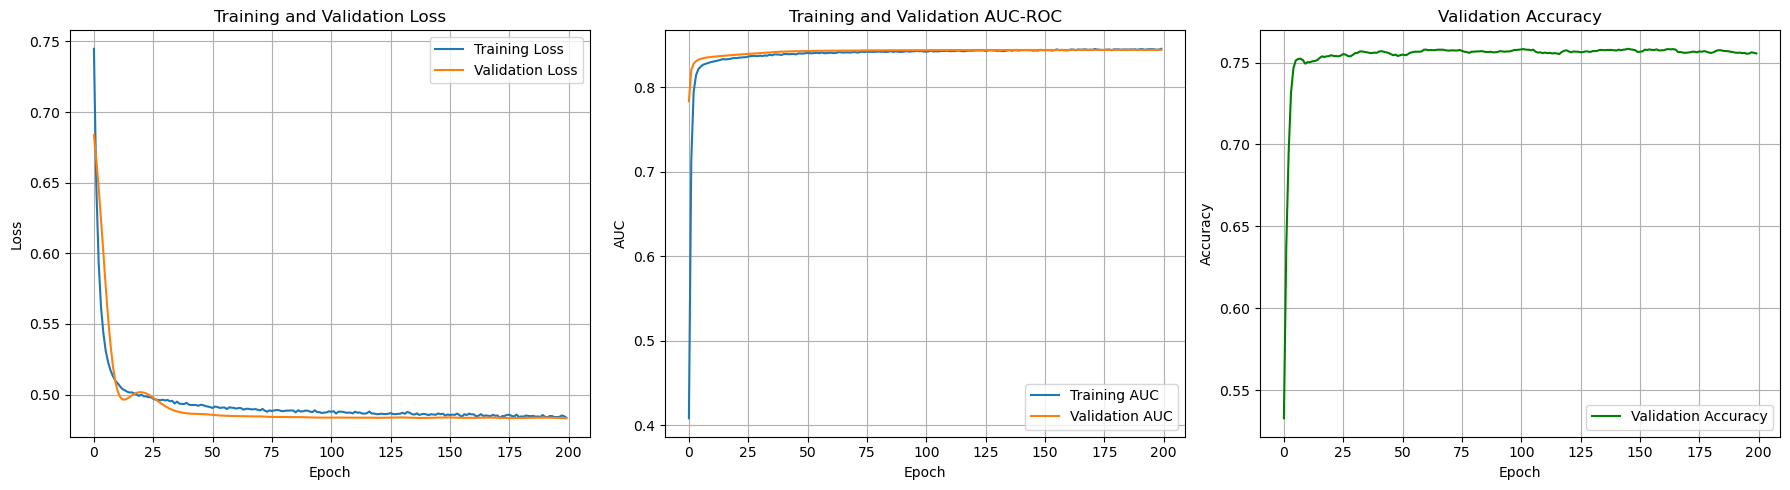

In [ ]:
import matplotlib.pyplot as plt
plt.figure(figsize=(18, 5)) 


plt.subplot(1, 3, 1) 
plt.plot(epoch_count, train_losses, label='Training Loss')
plt.plot(epoch_count, valid_losses, label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.subplot(1, 3, 2) 
plt.plot(epoch_count, train_auc_scores, label='Training AUC')
plt.plot(epoch_count, valid_auc_scores, label='Validation AUC')
plt.title('Training and Validation AUC-ROC')
plt.xlabel('Epoch')
plt.ylabel('AUC')
plt.legend()
plt.grid(True)


plt.subplot(1, 3, 3) 
plt.plot(epoch_count, valid_accuracies, label='Validation Accuracy', color='green') 
plt.title('Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy') 
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()



The model seems to converge well. So I will pick checkpoint 6